In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const

import lightkurve as lk

import sys
sys.path.append('/Users/james/Dropbox/research_projects/FFD/')
from FFD import FFD

from scipy.optimize import curve_fit

from astropy.timeseries import LombScargle

/Users/james/anaconda3/lib/python3.11/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/james/.lightkurve/cache. Please move all the files in the legacy directory /Users/james/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

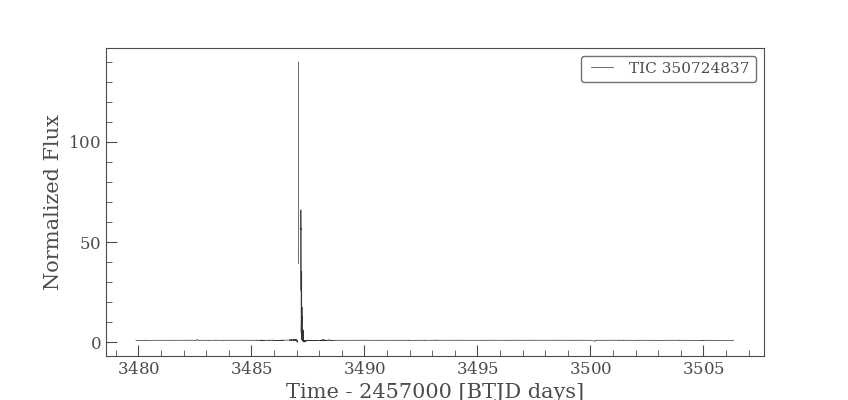

In [3]:
TESS = lk.search_lightcurve('278.5357759 9.5670520', mission='TESS').download_all()
TESS[0].plot()

In [4]:
TESS[0]['flux'].value

array([1.0017478 , 0.96876544, 0.980783  , ..., 0.9775089 , 0.9875273 ,
       0.99391925], dtype='>f4')

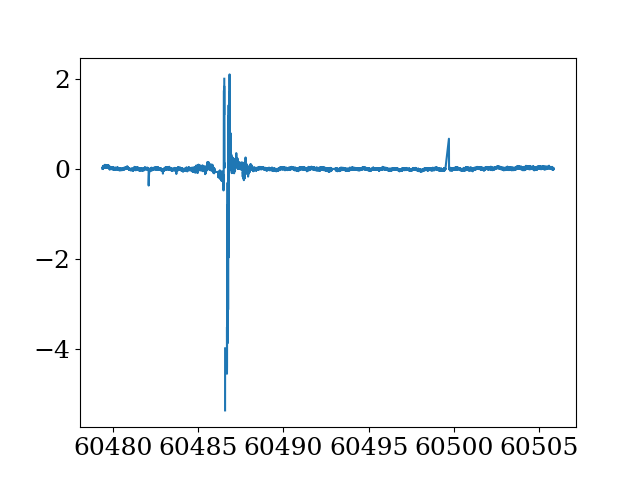

In [5]:
plt.figure()
plt.plot(TESS[0]['time'].value + 2457000 - 2400000.5, -2.5 * np.log10((TESS[0]['flux'].value/ np.nanmedian(TESS[0]['flux'].value))))

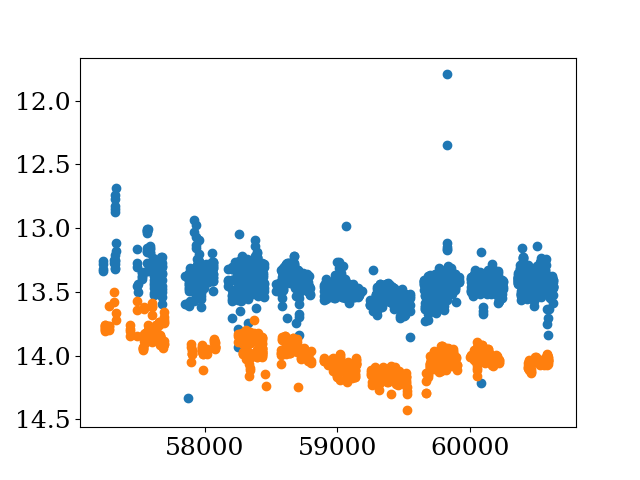

In [6]:
# ATLAS
atlas = pd.read_table('data/atlas_job1892282.txt', delim_whitespace=True)

ao = (atlas['F'] == 'o') & (atlas['dm'] < 0.05) & (atlas['m'] > 10)
ac = (atlas['F'] == 'c') & (atlas['dm'] < 0.05)  & (atlas['m'] > 10)

plt.figure()
plt.scatter(atlas['MJD'][ao], atlas['m'][ao]) 
plt.scatter(atlas['MJD'][ac], atlas['m'][ac])
plt.gca().invert_yaxis()

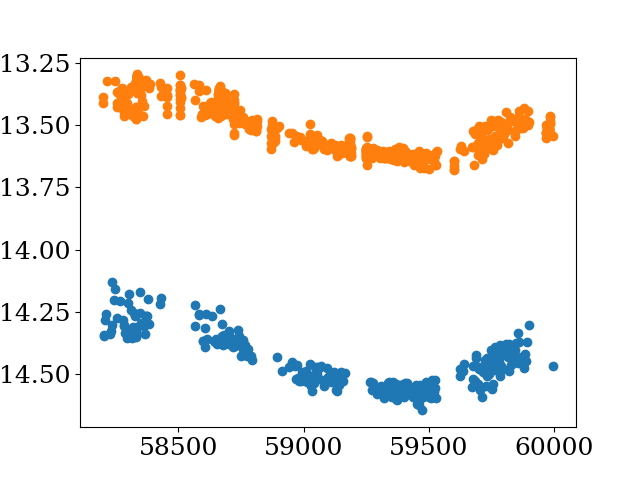

In [7]:
# ZTF
# from: https://ztf.snad.space/dr17/view/538202200014358
# need new ZTF data for more recent events (e.g. from Alert)
ztf = pd.read_csv('data/ZTF17_538202200014358.csv')

zr = ztf['filter'] == 'zr'
zg = ztf['filter'] == 'zg'

plt.figure()
plt.scatter(ztf['mjd'][zg], ztf['mag'][zg])
plt.scatter(ztf['mjd'][zr], ztf['mag'][zr])
plt.gca().invert_yaxis()

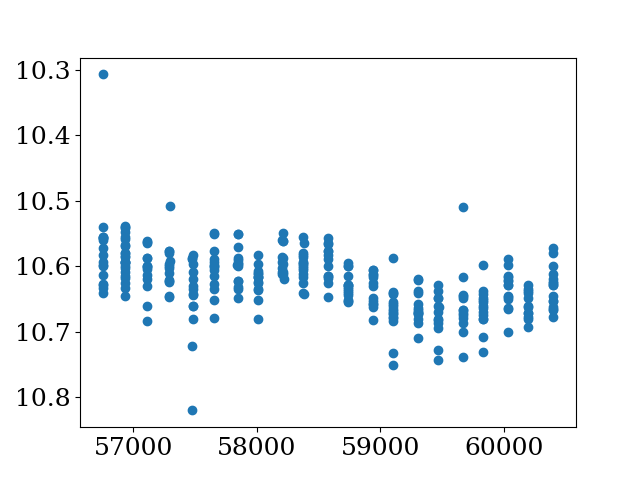

In [8]:
# WISE
wise = pd.read_csv('data/278.5357759 9.567052neowiser_p1bs_psd.csv')
plt.figure()
plt.scatter(wise['mjd'], wise['w1mpro'])
plt.gca().invert_yaxis()

In [203]:
#PanSTARRS
ps1=pd.read_csv('data/PS-12_6_2024.csv')

ps1.drop(ps1[ps1['objID'] != 119482785358220897].index, inplace=True)


In [219]:
fnums

array([3, 4, 5, 1, 2])

In [220]:
fnums = ps1['filterID'].unique()
filters = ['PS1-i','PS1-z','PS1-y','PS1-g','PS1-r']

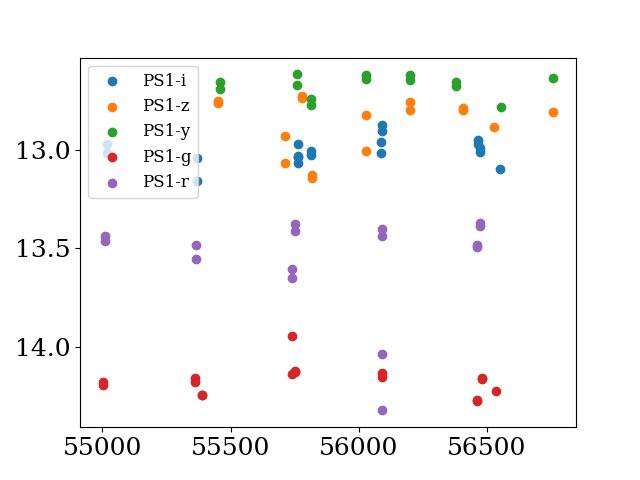

In [221]:
# flux to mag conversion: https://spacetelescope.github.io/notebooks/notebooks/MAST/PanSTARRS/PS1_DR2_TAP/PS1_DR2_TAP.html
plt.figure()
for k in range(len(fnums)):
    fk = ps1['filterID'] == fnums[k]
    plt.scatter(ps1['obsTime'][fk], -2.5*np.log10(ps1['psfFlux'][fk])+ 8.90, label=filters[k])
plt.legend(fontsize=12)
plt.gca().invert_yaxis()

In [196]:
ps1['objID']

array([119482785358220897, 119482785359210547, 119482785361200947])

In [202]:
sum(ps1['objID']!=119482785358220897)

0

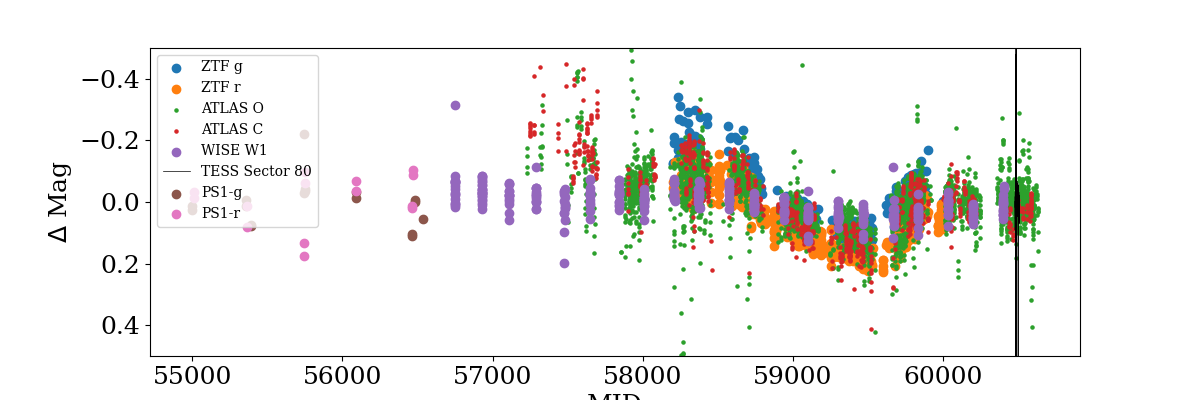

In [222]:
# combined...
plt.figure(figsize=(12,4))

plt.scatter(ztf['mjd'][zg], ztf['mag'][zg] - np.nanmedian(ztf['mag'][zg]), label='ZTF g')
plt.scatter(ztf['mjd'][zr], ztf['mag'][zr] - np.nanmedian(ztf['mag'][zr]), label='ZTF r')

plt.scatter(atlas['MJD'][ao], atlas['m'][ao] - np.nanmedian(atlas['m'][ao]),s=5, label='ATLAS O') 
plt.scatter(atlas['MJD'][ac], atlas['m'][ac] - np.nanmedian(atlas['m'][ac]),s=5, label='ATLAS C')

plt.scatter(wise['mjd'], wise['w1mpro'] - np.nanmedian(wise['w1mpro']), label='WISE W1')

#add TESS!
plt.plot(TESS[0]['time'].value + 2457000 - 2400000.5, -2.5 * np.log10((TESS[0]['flux'].value/ np.nanmedian(TESS[0]['flux'].value))), 
         c='k', lw=0.5, label='TESS Sector 80')

for k in [3,4]:
    fk = ps1['filterID'] == fnums[k]
    mags = -2.5*np.log10(ps1['psfFlux'][fk])+ 8.90
    plt.scatter(ps1['obsTime'][fk], mags - np.nanmedian(mags), label=filters[k])

plt.ylim(0.5,-0.5)
            
plt.legend(fontsize=10)
plt.ylabel('$\Delta$ Mag')
plt.xlabel('MJD')
plt.savefig('combined_LC.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

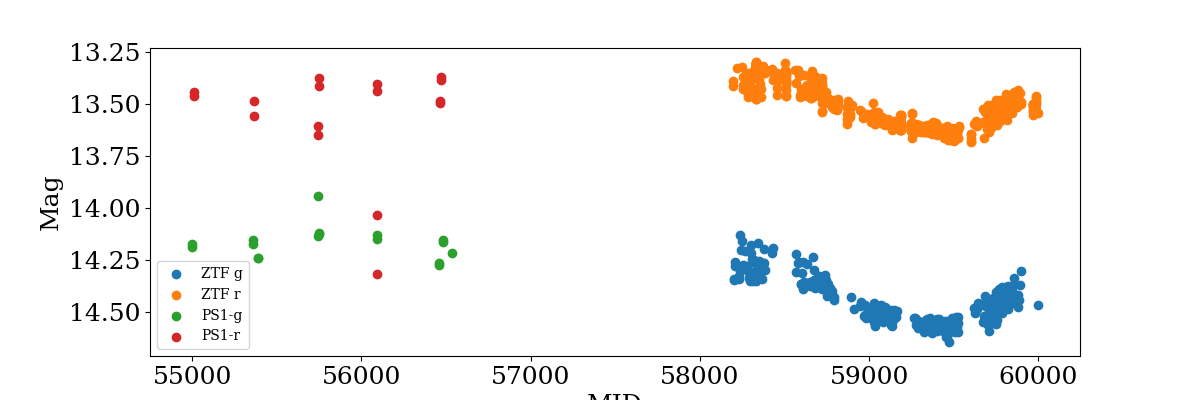

In [227]:
# combined...
plt.figure(figsize=(12,4))

plt.scatter(ztf['mjd'][zg], ztf['mag'][zg], label='ZTF g')
plt.scatter(ztf['mjd'][zr], ztf['mag'][zr], label='ZTF r')

# plt.scatter(atlas['MJD'][ao], atlas['m'][ao] - np.nanmedian(atlas['m'][ao]),s=5, label='ATLAS O') 
# plt.scatter(atlas['MJD'][ac], atlas['m'][ac] - np.nanmedian(atlas['m'][ac]),s=5, label='ATLAS C')

# plt.scatter(wise['mjd'], wise['w1mpro'] - np.nanmedian(wise['w1mpro']), label='WISE W1')

#add TESS!
# plt.plot(TESS[0]['time'].value + 2457000 - 2400000.5, -2.5 * np.log10((TESS[0]['flux'].value/ np.nanmedian(TESS[0]['flux'].value))), 
#          c='k', lw=0.5, label='TESS Sector 80')

for k in [3,4]:
    fk = ps1['filterID'] == fnums[k]
    mags = -2.5*np.log10(ps1['psfFlux'][fk])+ 8.90
    plt.scatter(ps1['obsTime'][fk], mags , label=filters[k])

# plt.ylim(0.5,-0.5)
plt.gca().invert_yaxis()
plt.legend(fontsize=10)
plt.ylabel('Mag')
plt.xlabel('MJD')
plt.savefig('PS1_ZTF_LC.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [233]:
# plt.figure()
# for k in [3,4]:
#     fk = ps1['filterID'] == fnums[k]
#     plt.errorbar(ps1['obsTime'][fk], ps1['psfFlux'][fk] , yerr=ps1['psfFluxErr'][fk],linestyle='none',label=filters[k])


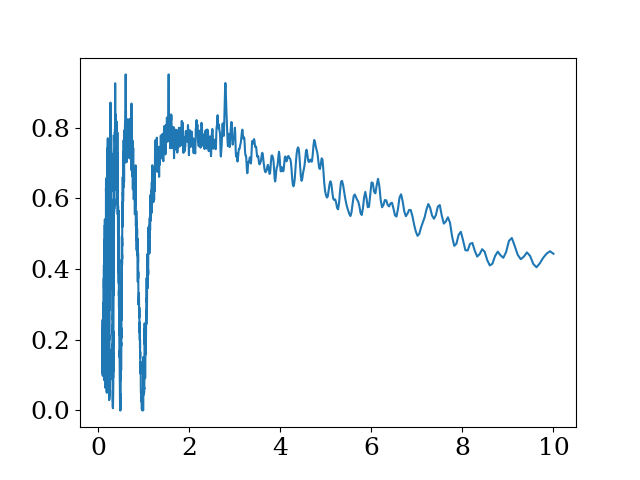

In [22]:
ze = ztf['mjd'][zr].values < 58500
frequency, power = LombScargle(ztf['mjd'][zr].values[ze], ztf['mag'][zr].values[ze]).autopower(minimum_frequency=0.1, maximum_frequency=10)

plt.figure()
plt.plot(1./frequency, power)
# plt.xscale("log")

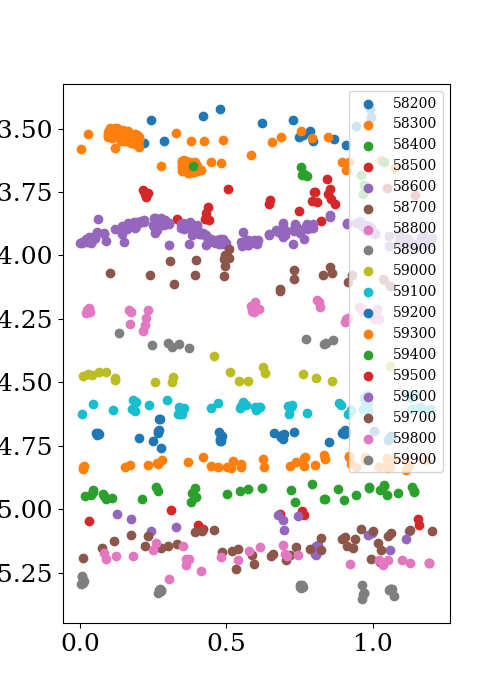

In [104]:
plt.figure(figsize=(5,7))

for k in range(30):
    # print(str(58100+(k*100)))
    ze = (ztf['mjd'][zr].values >= (58100+(k*100))) & (ztf['mjd'][zr].values < (58200+(k*100)))
    if sum(ze)>5:
        plt.scatter((ztf['mjd'][zr].values[ze] % 1.21), ztf['mag'][zr].values[ze]+(k*0.1), label=str(58100+(k*100)))
        # print(str(58100+(k*100)))
plt.gca().invert_yaxis()
# plt.legend(fontsize=10)

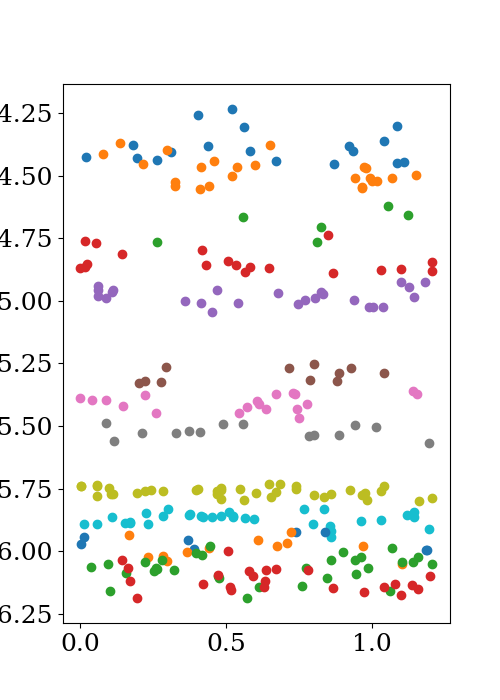

In [132]:
plt.figure(figsize=(5,7))

for k in range(30):
    # print(str(58100+(k*100)))
    ze = (ztf['mjd'][zg].values >= (58100+(k*100))) & (ztf['mjd'][zg].values < (58200+(k*100)))
    if sum(ze)>5:
        plt.scatter((ztf['mjd'][zg].values[ze] % 1.21), ztf['mag'][zg].values[ze]+(k*0.1), label=str(58100+(k*100)))
        # print(str(58100+(k*100)))
plt.gca().invert_yaxis()
# plt.legend(fontsize=10)

Text(0, 0.5, 'ZTF r (Mag)')

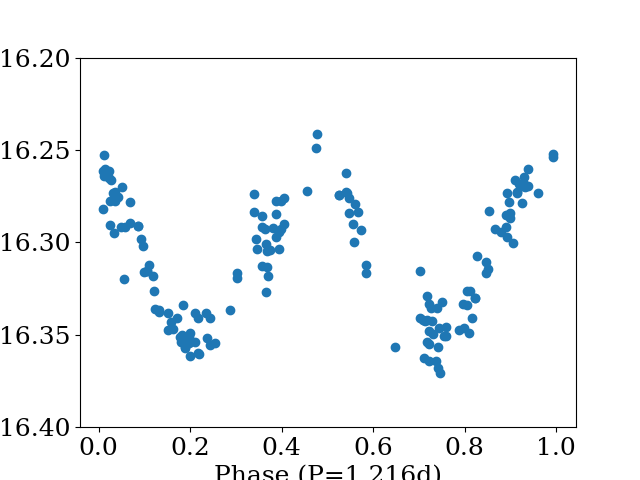

In [129]:
plt.figure()
ze = (ztf['mjd'][zr].values >= (58650)) & (ztf['mjd'][zr].values < (58700))
plt.scatter((ztf['mjd'][zr].values[ze] % 1.216) / 1.216, ztf['mag'][zr].values[ze]+(k*0.1), label=str(58100+(k*100)))

plt.gca().invert_yaxis()
plt.xlabel('Phase (P=1.216d)')
plt.ylim(16.4, 16.2)
plt.ylabel('ZTF r (Mag)')

# plt.legend(fontsize=10)

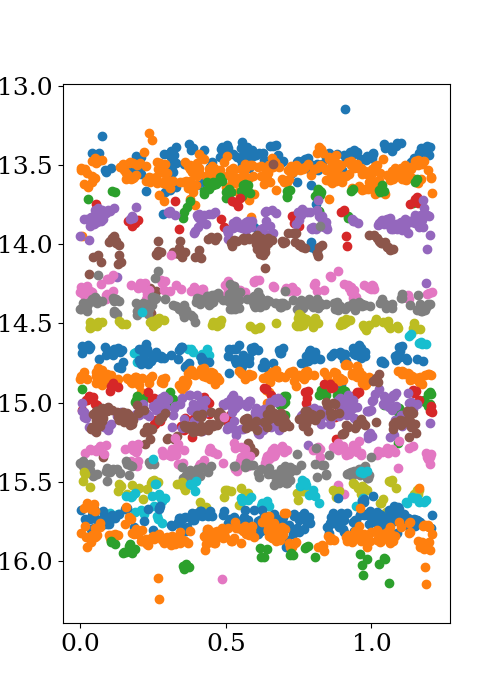

In [103]:
plt.figure(figsize=(5,7))

for k in range(30):
    # print(str(58100+(k*100)))
    ze = (atlas['MJD'][ao].values >= (58100+(k*100))) & (atlas['MJD'][ao].values < (58200+(k*100)))
    if sum(ze)>5:
        plt.scatter((atlas['MJD'][ao].values[ze] % 1.21), atlas['m'][ao].values[ze]+(k*0.1), label=str(58100+(k*100)))
        # print(str(58100+(k*100)))
plt.gca().invert_yaxis()
# plt.legend(fontsize=10)


# plt.scatter(atlas['MJD'][ao], atlas['m'][ao]) 


In [101]:
atlas['MJD'][ao].values

array([57230.361226, 57230.374178, 57230.41469 , ..., 60630.19186 ,
       60630.195083, 60630.200624])

(0.85, 1.12)

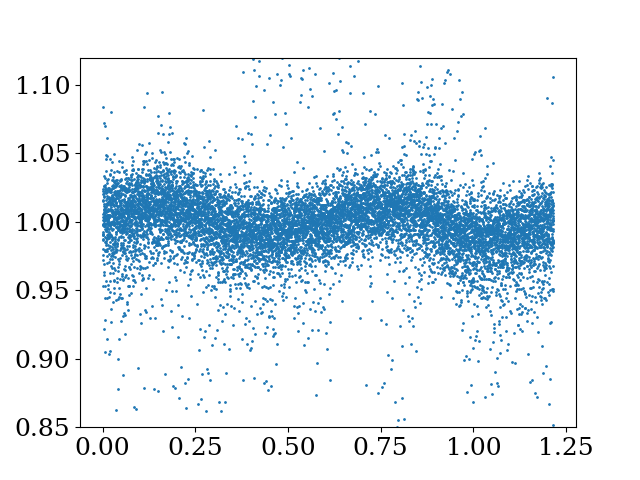

In [131]:
plt.figure()
# plt.scatter((ztf['mjd'][zr].values[ze] % 2.798)/2.798, ztf['mag'][zr].values[ze])
plt.scatter((TESS[0]['time'].value % 1.216), TESS[0]['flux'].value/ np.nanmedian(TESS[0]['flux'].value),s=1)
plt.ylim(.85, 1.12)

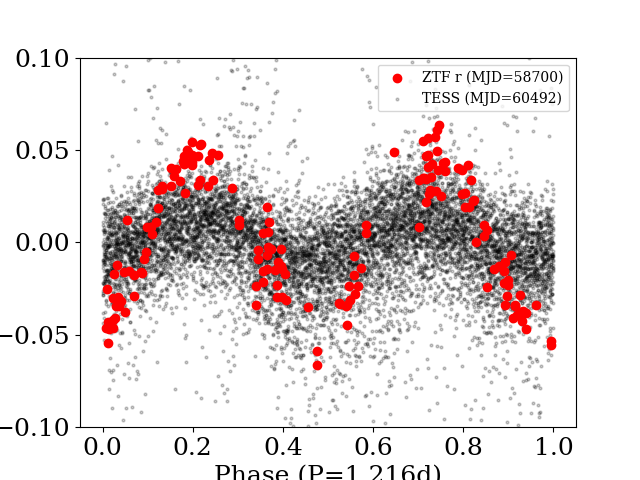

In [158]:
plt.figure()
ze = (ztf['mjd'][zr].values >= (58650)) & (ztf['mjd'][zr].values < (58700))
plt.scatter((ztf['mjd'][zr].values[ze] % 1.216) / 1.216, 
            ztf['mag'][zr].values[ze] - np.nanmedian(ztf['mag'][zr].values[ze]), label='ZTF r (MJD=58700)', c='r')

plt.scatter(((TESS[0]['time'].value + 2457000 - 2400000.5)% 1.216) / 1.216,
            2.5 * np.log10((TESS[0]['flux'].value/ np.nanmedian(TESS[0]['flux'].value))), 
            s=4, c='k', alpha=0.2,label='TESS (MJD=60492)', zorder=0)

plt.gca().invert_yaxis()
plt.xlabel('Phase (P=1.216d)')
plt.ylim(-.1,0.1)
plt.ylabel(r'$\Delta$ Mag')
plt.legend(fontsize=10)
plt.savefig('ZTF24aaerzwh_per.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')


In [142]:
TESS[0].sector

80

In [151]:
np.nanmedian(TESS[0]['time'].value + 2457000 - 2400000.5)

60492.514494923875

In [155]:
0.607446*2

1.214892

In [166]:
from astropy.coordinates import SkyCoord
import astropy.units as units
from dustmaps.bayestar import BayestarQuery

#### Run these first time only ####
# from dustmaps.config import config
# config.reset()

# from dustmaps.config import config
# config['data_dir'] = '~/.dustmaps/'

# import dustmaps.bayestar
# dustmaps.bayestar.fetch()

694.1 MiB of 694.2 MiB |   1.6 MiB/s |################# |  99% | ETA:   0:00:0037

In [167]:
bayestar = BayestarQuery(version='bayestar2019') # 'bayestar2019' is the default
coords = SkyCoord(278.5357759*units.deg, 9.5670520*units.deg,
                  distance=231.617*units.pc, frame='icrs')

reddening = bayestar(coords, mode='median')
print(reddening)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 21.010 s
  pix_info:   0.301 s
   samples:  11.283 s
      best:   2.241 s
       nan:   0.042 s
      sort:   7.079 s
       idx:   0.065 s
0.11


Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 11.948 s
  pix_info:   0.296 s
   samples:   2.257 s
      best:   2.311 s
       nan:   0.034 s
      sort:   6.990 s
       idx:   0.061 s


(-0.5, 199.5, -0.5, 139.5)

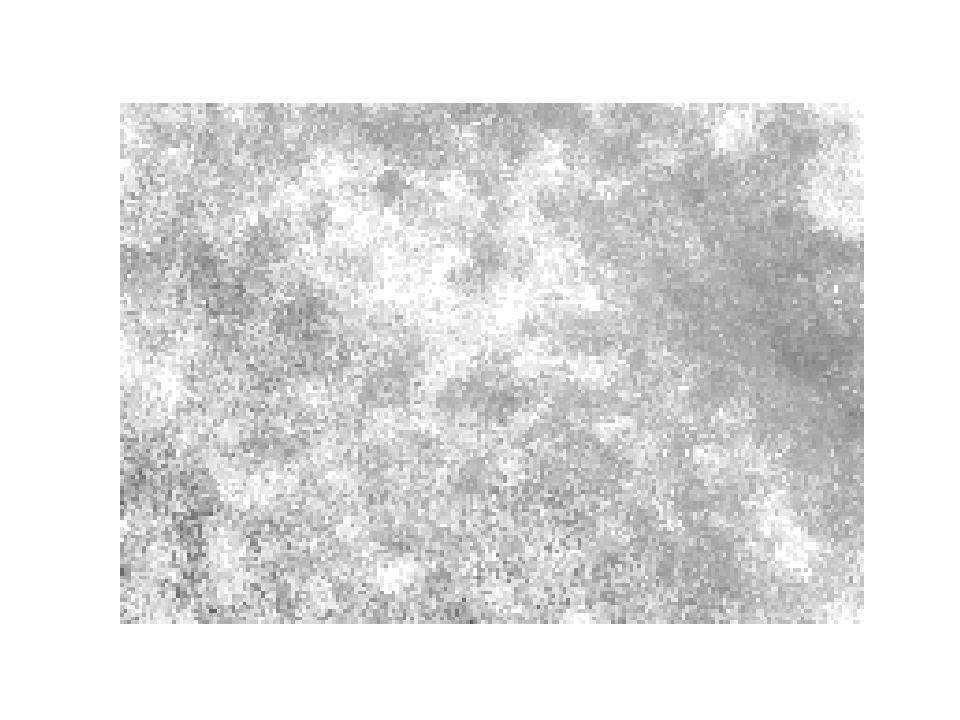

In [180]:
# https://dustmaps.readthedocs.io/en/latest/examples.html

l0, b0 = (278.5357759, 9.5670520) # the RA,Dec coords
ra = np.arange(l0 - 5., l0 + 5., 0.05)
dec = np.arange(b0 - 5., b0 + 2., 0.05)
ra,dec = np.meshgrid(ra,dec)

coords = SkyCoord(ra*units.deg, dec*units.deg,
                  distance=231.617*units.pc, frame='icrs')

bayestar = BayestarQuery(max_samples=1)
Av_bayestar = 2.742 * bayestar(coords)

fig = plt.figure(dpi=150)

ax = fig.add_subplot(1,1,1)
ax.imshow(
    np.sqrt(Av_bayestar)[::,::-1],
    vmin=0.,
    vmax=2.,
    origin='lower',
    interpolation='nearest',
    cmap='binary',
    aspect='equal'
)
ax.axis('off')
# ax.set_title(title)
